<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h1 align="center" style="color:#ffffff;"><b>Goodreads Books Recommendation System 📚📖🔍</b></h1>
</div>

<div style="background-color:#000000; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <img src="https://media.tenor.com/0kKOC3ge6SkAAAAd/doctor-strange-nope.gif" alt="Animated GIF">
</div>

In [1]:
!pip3 install -q plotly wordcloud

<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>IMPORT DEPENDENCIES</b></h2>
</div>

In [2]:
import re
import numpy  as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as colors
from wordcloud import WordCloud
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")

In [3]:
books_data = pd.read_csv("/kaggle/input/goodreadsbooks/books.csv", on_bad_lines='skip')
books_data.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>DATA PRE-PROCESSING AND EDA</b></h2>
</div>

In [4]:
books_data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [5]:
# Rename columns
new_column_names = {
    'bookID': 'book_id',
    'title': 'title',
    'authors': 'authors',
    'average_rating': 'average_rating',
    'isbn': 'isbn',
    'isbn13': 'isbn13',
    'language_code': 'language_code',
    '  num_pages':'num_of_pages',
    'ratings_count': 'ratings_count',
    'text_reviews_count': 'text_reviews_count',
    'publication_date': 'publication_date',
    'publisher': 'publisher'
}

books_data = books_data.rename(columns=new_column_names)
books_data.head()

,book_id,title,authors,average_rating,isbn,isbn13,language_code,num_of_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [6]:
books_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   book_id             11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7   num_of_pages        11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [7]:
print(f"dataset contains {books_data.shape[0]} rows and {books_data.shape[1]} columns")

dataset contains 11123 rows and 12 columns


In [8]:
# What are the most frequently repeated books on the list? (Top 20 books)
top_20_books = books_data['title'].value_counts()[:20]

# Define a color palette with enough unique colors
color_palette = colors.qualitative.Plotly

# Create a list of distinct colors for each bar
bar_colors = [color_palette[i % len(color_palette)] for i in range(len(top_20_books))]

# Create a Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=top_20_books,
    y=top_20_books.index,
    orientation='h',
    marker=dict(color=bar_colors)  # Set the bar colors using the list of colors
)])

# Update the layout with dark background and white font
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    title="Most Occurring Books",
    xaxis_title="Number of occurrences",
    yaxis_title="Books"
)

# Show the plot
fig.show()

In [9]:
### What are the top 20 rated books?
# Sort the dataframe by ratings_count in descending order and select the top 20
top_20_most_rated_books = books_data.sort_values('ratings_count', ascending=False).head(20)

# Define the number of bars and obtain a color palette with enough unique colors
num_bars = len(top_20_most_rated_books)
color_palette = colors.qualitative.Set3

# Create a list of distinct colors for each bar
bar_colors = color_palette[:num_bars]

# Create a Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=top_20_most_rated_books['ratings_count'],
    y=top_20_most_rated_books['title'],
    orientation='h',
    marker=dict(color=bar_colors)  # Set the bar colors using the list of colors
)])

# Update the layout with dark background and white font
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    title="Top 20 Most Rated Books",
    xaxis_title="Number of Ratings",
    yaxis_title="Book Title"
)

# Show the plot
fig.show()

In [10]:
## What is the language distribution of books?
# Count the number of books for each language code
language_counts = books_data['language_code'].value_counts()

# Define a color palette with enough unique colors
color_palette = colors.qualitative.Set3

# Create a Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=language_counts.index,
    y=language_counts,
    marker=dict(color=color_palette)  # Set the bar colors using the color palette
)])

# Update the layout with dark background and white font
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    title="Distribution of Books for Language Codes",
    xaxis_title="Language Code",
    yaxis_title="Count"
)

# Show the plot
fig.show()

In [11]:
print(list(books_data['language_code'].value_counts().index))

['eng', 'en-US', 'spa', 'en-GB', 'fre', 'ger', 'jpn', 'mul', 'zho', 'grc', 'por', 'en-CA', 'ita', 'enm', 'lat', 'swe', 'rus', 'srp', 'nl', 'msa', 'glg', 'wel', 'ara', 'nor', 'tur', 'gla', 'ale']


In [12]:
## Which authors have the most books? (Top 20)
# Group the dataframe by authors and count the number of titles for each author
most_books = books_data.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(20)

# Create a Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=most_books['title'],
    y=most_books['authors'],
    orientation='h',
    marker=dict(color=colors.qualitative.Pastel)  # Set the bar colors using a qualitative color palette
)])

# Update the layout with dark background and white font
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    title="Top 20 Authors with Most Books",
    xaxis_title="Total Number of Books",
    yaxis_title="Authors"
)

# Add labels to the bars
for i, val in enumerate(most_books['title']):
    fig.add_annotation(
        x=val + 0.3,
        y=most_books['authors'].iloc[i],
        text=str(val),
        font=dict(color='black', size=10),
        showarrow=False
    )

# Show the plot
fig.show()

In [13]:
## Top 20 Authors with Highest Rated Books

high_rated_author = books_data[books_data['average_rating'] >= 4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(20)

# Define the number of bars and obtain a color palette with enough unique colors
num_bars = len(high_rated_author)
color_palette = colors.qualitative.Set2

# Create a list of distinct colors for each bar
bar_colors = color_palette[:num_bars]

# Create a Plotly bar plot
fig = go.Figure(data=[go.Bar(
    x=high_rated_author['title'],
    y=high_rated_author['authors'],
    orientation='h',
    marker=dict(color=bar_colors)  # Set the bar colors using the list of colors
)])

# Update the layout with dark background and white font
fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    title="Top 20 Authors with Highest Rated Books",
    xaxis_title="Number of Books",
    yaxis_title="Authors"
)

# Show the plot
fig.show()

In [14]:
rating = books_data['average_rating'].astype(float)

fig = px.histogram(rating, histnorm='density')

fig.update_layout(
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    title="Distribution of Average Ratings",
    xaxis_title="Average Rating",
    yaxis_title="Density"
)

fig.show()

In [15]:
def segregate(data):
    values = []
    for val in data.average_rating:
        if val >= 0 and val <= 1:
            values.append("Between 0 and 1")
        elif val > 1 and val <= 2:
            values.append("Between 1 and 2")
        elif val > 2 and val <= 3:
            values.append("Between 2 and 3")
        elif val > 3 and val <= 4:
            values.append("Between 3 and 4")
        elif val > 4 and val <= 5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    return values

In [16]:
books_data['ratings_dist'] = segregate(books_data)
books_data.head()

,book_id,title,authors,average_rating,isbn,isbn13,language_code,num_of_pages,ratings_count,text_reviews_count,publication_date,publisher,ratings_dist
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,Between 4 and 5
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,Between 4 and 5
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Between 4 and 5
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Between 4 and 5
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Between 4 and 5


In [17]:
print(books_data['ratings_dist'].value_counts().index)
print(books_data['ratings_dist'].value_counts().values)

Index(['Between 3 and 4', 'Between 4 and 5', 'Between 2 and 3',
       'Between 0 and 1', 'Between 1 and 2'],
      dtype='object')
[6285 4735   69   27    7]


In [18]:
## ratings_dist
labels = books_data['ratings_dist'].value_counts().index
values = books_data['ratings_dist'].value_counts().values

colors = ['lightblue', 'darkmagenta', 'coral', 'bisque', 'black']

fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=values,
    hole=0.5,
    marker=dict(colors=colors, line=dict(color='#000000', width=1)),
)])

fig.update_layout(
    title="Distribution of Ratings",
    plot_bgcolor='rgb(17, 17, 17)',
    paper_bgcolor='rgb(17, 17, 17)',
    font=dict(color='white'),
)

fig.show()

In [19]:
## Is there any relationship between ratings and review counts?
fig = go.Figure(data=go.Scatter(
    x=books_data['average_rating'],
    y=books_data['text_reviews_count'],
    mode='markers',
    marker=dict(
        color='green',
        size=8,
        opacity=0.5
    )
))

fig.update_layout(
    title="Relationship between Ratings and Review Counts",
    xaxis_title="Average Rating",
    yaxis_title="Text Review Count",
    plot_bgcolor='rgb(17, 17, 17)',
    paper_bgcolor='rgb(17, 17, 17)',
    font=dict(color='white')
)

fig.show()

In [20]:
##  Is there a relationship between number of pages and ratings?

fig = go.Figure(data=go.Scatter(
    x=books_data['num_of_pages'],
    y=books_data['average_rating'],
    mode='markers',
    marker=dict(
        color='blue',
        size=8,
        opacity=0.5
    )
))

fig.update_layout(
    title="Relationship between Number of Pages and Ratings",
    xaxis_title="Number of Pages",
    yaxis_title="Average Rating",
    plot_bgcolor='rgb(17, 17, 17)',
    paper_bgcolor='rgb(17, 17, 17)',
    font=dict(color='white')
)

fig.show()

In [21]:
most_text = books_data.sort_values('text_reviews_count', ascending=False).head(20)

fig = go.Figure(data=[
    go.Bar(
        x=most_text['text_reviews_count'],
        y=most_text['title'],
        orientation='h',
        marker=dict(color=most_text['text_reviews_count'], coloraxis='coloraxis'),
    )
])

fig.update_layout(
    title='Top 20 Books with Highest Reviews',
    xaxis_title='Text Reviews Count',
    yaxis_title='Book Title',
    plot_bgcolor='rgb(17, 17, 17)',  # Dark background color
    paper_bgcolor='rgb(17, 17, 17)',  # Dark background color
    font=dict(color='white'),  # White font color
    coloraxis=dict(colorscale='magma'),
)

fig.show()


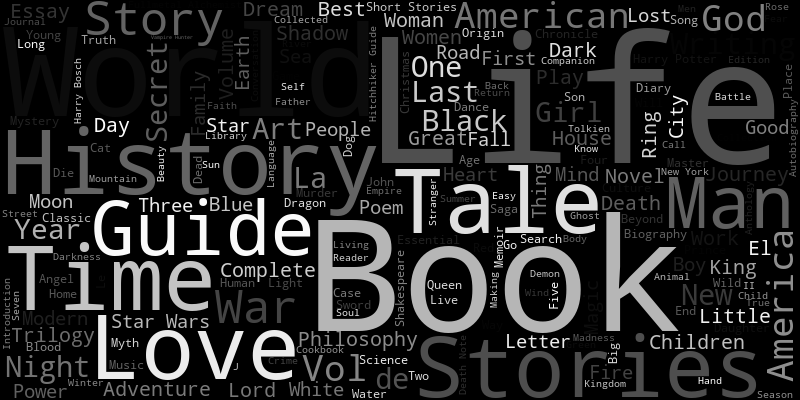

In [22]:
## Titles Word Cloud
# Concatenate all book titles into a single string
text = ' '.join(books_data['title'])

# Create a WordCloud object with dark background and white font color
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='black',
    colormap='gray',
    contour_color='white',
    contour_width=2,
).generate(text)
# Generate the word cloud image
wordcloud_image = wordcloud.to_image()
# Create a plotly figure and add the word cloud image
fig = go.Figure()
fig.add_layout_image(
    source=wordcloud_image,
    x=0.5, y=0.5,
    xref='paper', yref='paper',
    sizex=1, sizey=1,
    xanchor='center', yanchor='middle'
)

# Set the layout properties
fig.update_layout(
    title='Book Titles Word Cloud',
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    plot_bgcolor='black',
    showlegend=False,
    font=dict(color='black')
)

# Display the figure
fig.show()

In [23]:
books_data.head()

,book_id,title,authors,average_rating,isbn,isbn13,language_code,num_of_pages,ratings_count,text_reviews_count,publication_date,publisher,ratings_dist
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,Between 4 and 5
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,Between 4 and 5
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,Between 4 and 5
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,Between 4 and 5
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,Between 4 and 5


In [24]:
books_database = books_data[['book_id','title','authors','average_rating','num_of_pages','ratings_count','text_reviews_count','publisher','ratings_dist']]
books_database.head()

,book_id,title,authors,average_rating,num_of_pages,ratings_count,text_reviews_count,publisher,ratings_dist
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,652,2095690,27591,Scholastic Inc.,Between 4 and 5
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,870,2153167,29221,Scholastic Inc.,Between 4 and 5
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,6333,244,Scholastic,Between 4 and 5
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,435,2339585,36325,Scholastic Inc.,Between 4 and 5
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,2690,41428,164,Scholastic,Between 4 and 5


In [25]:
books_database['ratings_dist'] = books_database['ratings_dist'].replace({
    'Between 0 and 1':0,
    'Between 1 and 2':1,
    'Between 2 and 3':2,
    'Between 3 and 4':3,
    'Between 4 and 5':4
});
books_database.head()

,book_id,title,authors,average_rating,num_of_pages,ratings_count,text_reviews_count,publisher,ratings_dist
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,652,2095690,27591,Scholastic Inc.,4
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,870,2153167,29221,Scholastic Inc.,4
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,6333,244,Scholastic,4
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,435,2339585,36325,Scholastic Inc.,4
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,2690,41428,164,Scholastic,4


<div style="background-color:blue; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>MODEL ENGINEERING</b></h2>
</div>

In [26]:
# Creating an instance of the NearestNeighbors model
model = NearestNeighbors(n_neighbors=6, algorithm='ball_tree')

# Fitting the model to the feature matrix of books
model.fit(books_database[['average_rating','num_of_pages','ratings_count','text_reviews_count','ratings_dist']])

# Querying the model to find the nearest neighbors
distance, indices = model.kneighbors(books_database[['average_rating','num_of_pages','ratings_count','text_reviews_count','ratings_dist']])

In [27]:
indices.shape

(11123, 6)

In [28]:
books_database['indices'] = indices.tolist()
books_database['distance']= distance.tolist()
books_database.head()

,book_id,title,authors,average_rating,num_of_pages,ratings_count,text_reviews_count,publisher,ratings_dist,indices,distance
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,652,2095690,27591,Scholastic Inc.,4,"[0, 2114, 23, 1, 2116, 4415]","[0.0, 16203.576685707387, 36051.17575120262, 5..."
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,870,2153167,29221,Scholastic Inc.,4,"[1, 23, 2114, 0, 2116, 4415]","[0.0, 28789.06240253232, 41426.26377448973, 57..."
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,6333,244,Scholastic,4,"[2, 254, 8166, 839, 10615, 7824]","[0.0, 77.3889714365038, 78.23977505080137, 85...."
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,435,2339585,36325,Scholastic Inc.,4,"[3, 4415, 307, 1462, 1, 1697]","[0.0, 45651.31333291081, 80564.4579665804, 117..."
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,2690,41428,164,Scholastic,4,"[4, 1643, 7870, 4143, 5456, 3624]","[0.0, 2022.5205749509694, 2100.808411088455, 2..."


<div style="background-color:BLUE; border-radius:2px; border:#000000 solid; padding: 15px; font-size:100%; text-align:center">
    <h2 align="center" style="color:#ffffff;"><b>_ GoodReads Books Recommendation System 🎬 (BOOK-QUEST) _</b></h2>
</div>

In [29]:
books_database.to_csv('BOOKSDB.csv',index=False)

In [30]:
class BookQuest:
    def __init__(self, dataframe, indices):
        self.df = dataframe
        self.indices = indices
        self.all_books_names = list(self.df["title"].values)
    
    def find_id(self,name):
        for index,string in enumerate(self.all_books_names):
            if re.search(name,string):
                index=index;
                break;
        return(index)

    def print_similar_books(self, query=None):
        if query:
            found_id = self.find_id(query)
            for id in self.indices[found_id][1:]:
                print(self.df.iloc[id]["title"])

In [31]:
recsys = BookQuest(books_database,books_database.indices)
recsys.print_similar_books("The Hobbit or There and Back Again")
print("-----------------------------------------------")
recsys.print_similar_books("Harry Potter")

Living La Dolce Vita: Bring the Passion  Laughter  and Serenity of Italy Into Your Daily Life
Penguin Book Of Norse Myths: Gods Of The Vikings
Body Language (Mark Manning Mystery  #3)
The Essential Augustine
Tales From Shakespeare
-----------------------------------------------
Animal Farm
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Order of the Phoenix (Harry Potter  #5)
Lord of the Flies
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
